In [1]:
# Import code and data.

import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import njit

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
data_summary = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
data_summary = data_summary[data_summary['Experiment'] == experiment]
wind_dir = data_summary['Wind_Dir'].values[0]
wind_speed = data_summary['WindSpeed'].values[0]

# Convert lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - data_summary['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - data_summary['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']

# Modify concentrations.
all_data['Concentration'] = all_data['Concentration']

# Split data, 80% for training and 20% for testing, shuffling rows first.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon'])
all_data = np.asarray(all_data)   # Prepare for Numba.
np.random.seed(1)                 # Ensure the same split each time.
np.random.shuffle(all_data)
training_data, testing_data = np.split(all_data, [int(0.8 * len(all_data))])

# Release unused memory.
del(all_data)
del(data_summary)
del(experiment)
del(wind_dir)
gc.collect()

0

In [2]:
# Model parameter and functions setup.

# Inference and model parameters.
H = np.float64(0.0)
#prior_param_1 = np.array([0.33, 0.86, 1.1e-3])   # Legacy settings for k_a, k_b, k_Q.
#prior_param_2 = np.array([1.0, 1.0, 1e-3])       # Legacy settings for theta_a, theta_b, theta_Q.
prior_param_1 = np.array([0.33, 0.86, 100, 100])
prior_param_2 = np.array([1.0, 1.0, 10, 10])


################################################################################

# Non-jitted functions.

# Function for calculating the conditional probability for parameters a, b or Q.
def log_prob_params(params, prior_param_1, prior_param_2, log_lhood, dist):

    if dist == 'uniform':
        return log_lhood
    elif dist == 'gamma':
        return (prior_param_1 - 1) * np.log(params) - params / prior_param_2 + log_lhood
    elif dist == 'gaussian':
        return -(params - prior_param_1) **2 / (2 * prior_param_2 ** 2) + log_lhood


# MCMC Sampler for a, b or Q.
def sample_params(current_params, current_sigma, prior_param_1, prior_param_2, ss, precalc2a, precalc2, condition, N_data, dist):

    # Set current and proposed values for a, b, Q and sigma.
    # np.random.normal generates random numbers from a normal distribution.
    proposed_params = np.random.normal(loc = current_params, scale = ss)

    # Calculating the conditional probability of current and proposed a, b, Q and sigma.
    # It's assumed that "condition" is either 0 or 1, and only 1 when dealing with sigma.
    if condition:
        tmp = np.sqrt(2 * np.pi)
        log_l_curr_params = precalc2a - N_data * np.log(tmp * current_sigma)
        log_l_prop_params = precalc2 / proposed_params**2 - N_data * np.log(tmp * proposed_params)
    else:
        log_l_curr_params = precalc2a
        log_l_prop_params = precalc2 / current_sigma**2

    # Though an ostensibly unnecessary variable declaration (the logic can be added directly inside the np.exp call below),
    # it's needed for correct Numba execution.
    log_p_prop_params = log_prob_params(proposed_params, prior_param_1, prior_param_2, log_l_prop_params, dist)

    # Acceptance criteria.
    # N.B. Using parameter names in "uniform" breaks Numba.
    if np.random.uniform(0.0, 1.0) < np.exp(log_p_prop_params - log_prob_params(current_params, prior_param_1, prior_param_2, log_l_curr_params, dist)):
        return proposed_params, 1
    else:
        return current_params, 0


# Full MCMC sampler.
def sample_process(N_samples, ss, u, H, data, params_init, prior_param_2):

    np.random.seed(117)   # Seed the Numba rng.

    # Intialisation.
    # - Pre-allocate memory space for data where relevant.
    # - Variables declared in order of largest to smallest.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    #
    params_means = np.empty((N_samples, len(params_init)), np.float64)    # rows = N_samples, cols = len(params_init). Use rounded brackets, not square, for "empty" in Numba.
    params_means[:] = np.NaN
    params_samples = params_means.copy()
    params = params_init.copy()
    #
    params_init = 1 - params_init
    #
    piu = np.pi * u                      # Saved as np.float64.
    accept_tot_0 = 0                     # Saved as integer.
    accept_tot_1 = 0                     # Saved as integer.
    accept_tot_2 = 0                     # Saved as integer.
    accept_tot_3 = 0                     # Saved as integer.
    count = 0                            # Saved as integer.
    N_data = data[:,1].size

    for j in range(N_samples):

        count = count + 1
        if (count % 10000 == 0):
            print('Running sample ' + str(count) + '...')

        # Column 1 holds "x" values.
        precalc1 = 2.0 * params[0] * data[:,1] ** params[1]
        # Column 0 holds "Concentration" values.
        precalc2 = -sum((params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2) / 2
        precalc2a = precalc2 / params[3]**2

        params[0], accept_0 = sample_params(params[0], params[3], params_init[0], prior_param_2[0], ss[0], precalc2a, precalc2, 0, N_data, 'uniform')   # a
        params[1], accept_1 = sample_params(params[1], params[3], params_init[1], prior_param_2[1], ss[1], precalc2a, precalc2, 0, N_data, 'uniform')   # b
        params[2], accept_2 = sample_params(params[2], params[3], params_init[2], prior_param_2[2], ss[2], precalc2a, precalc2, 0, N_data, 'uniform')   # Q
        params[3], accept_3 = sample_params(params[3], params[3], params_init[3], prior_param_2[3], ss[3], precalc2a, precalc2, 1, N_data, 'uniform')   # sigma

        accept_tot_0 += accept_0
        accept_tot_1 += accept_1
        accept_tot_2 += accept_2
        accept_tot_3 += accept_3

        params_samples[j] = params
        #params_means[j] = np.mean(params_samples[:count, :], axis = 0)   # Numba doesn't support an axis argument for "mean".
        params_means[j, 0] = np.mean(params_samples[:count, 0:1])
        params_means[j, 1] = np.mean(params_samples[:count, 1:2])
        params_means[j, 2] = np.mean(params_samples[:count, 2:3])
        params_means[j, 3] = np.mean(params_samples[:count, 3:4])

    print('Sampling complete.')
    print('a Acceptance Rate: ', accept_tot_0 / N_samples)
    print('b Acceptance Rate: ', accept_tot_1 / N_samples)
    print('Q Acceptance Rate: ', accept_tot_2 / N_samples)
    print('sigma Acceptance Rate: ', accept_tot_3 / N_samples)

    return params_samples, params_means


################################################################################

# Jitted versions of the sampling functions.

# Function for calculating the conditional probability for parameters a, b or Q.
@njit(nogil=True)
def log_prob_params_jit(params, prior_param_1, prior_param_2, log_lhood, dist):

    if dist == 'uniform':
        return log_lhood
    elif dist == 'gamma':
        return (prior_param_1 - 1) * np.log(params) - params / prior_param_2 + log_lhood
    elif dist == 'gaussian':
        return -(params - prior_param_1) **2 / (2 * prior_param_2 ** 2) + log_lhood


# MCMC Sampler for a, b or Q.
@njit(nogil=True)
def sample_params_jit(current_params, current_sigma, prior_param_1, prior_param_2, ss, precalc2a, precalc2, condition, N_data, dist):

    # Set current and proposed values for a, b, Q and sigma.
    # np.random.normal generates random numbers from a normal distribution.
    proposed_params = np.random.normal(loc = current_params, scale = ss)

   # Calculating the conditional probability of current and proposed a, b, Q and sigma.
    # It's assumed that "condition" is either 0 or 1, and only 1 when dealing with sigma.
    if condition:
        tmp = np.sqrt(2 * np.pi)
        log_l_curr_params = precalc2a - N_data * np.log(tmp * current_sigma)
        log_l_prop_params = precalc2 / proposed_params**2 - N_data * np.log(tmp * proposed_params)
    else:
        log_l_curr_params = precalc2a
        log_l_prop_params = precalc2 / current_sigma**2

    # Though an ostensibly unnecessary variable declaration (the logic can be added directly inside the np.exp call below),
    # it's needed for correct Numba execution.
    log_p_prop_params = log_prob_params_jit(proposed_params, prior_param_1, prior_param_2, log_l_prop_params, dist)

    # Acceptance criteria.
    # N.B. Using parameter names in "uniform" breaks Numba.
    if np.random.uniform(0.0, 1.0) < np.exp(log_p_prop_params - log_prob_params_jit(current_params, prior_param_1, prior_param_2, log_l_curr_params, dist)):
        return proposed_params, 1
    else:
        return current_params, 0


# Full MCMC sampler.
@njit(nogil=True)
def sample_process_jit(N_samples, ss, u, H, data, params_init, prior_param_2):

    np.random.seed(117)   # Seed the Numba rng.

    # Intialisation.
    # - Pre-allocate memory space for data where relevant.
    # - Variables declared in order of largest to smallest.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    #
    params_means = np.empty((N_samples, len(params_init)), np.float64)    # rows = N_samples, cols = len(params_init). Use rounded brackets, not square, for "empty" in Numba.
    params_means[:] = np.NaN
    params_samples = params_means.copy()
    params = params_init.copy()
    #
    params_init = 1 - params_init
    #
    piu = np.pi * u                      # Saved as np.float64.
    accept_tot_0 = 0                     # Saved as integer.
    accept_tot_1 = 0                     # Saved as integer.
    accept_tot_2 = 0                     # Saved as integer.
    accept_tot_3 = 0                     # Saved as integer.
    count = 0                            # Saved as integer.
    N_data = data[:,1].size

    for j in range(N_samples):

        count = count + 1
        if (count % 10000 == 0):
            print('Running sample ' + str(count) + '...')

        # Column 1 holds "x" values.
        precalc1 = 2.0 * params[0] * data[:,1] ** params[1]
        # Column 0 holds "Concentration" values.
        precalc2 = -sum((params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2) / 2
        precalc2a = precalc2 / params[3]**2

        params[0], accept_0 = sample_params_jit(params[0], params[3], params_init[0], prior_param_2[0], ss[0], precalc2a, precalc2, 0, N_data, 'uniform')   # a
        params[1], accept_1 = sample_params_jit(params[1], params[3], params_init[1], prior_param_2[1], ss[1], precalc2a, precalc2, 0, N_data, 'uniform')   # b
        params[2], accept_2 = sample_params_jit(params[2], params[3], params_init[2], prior_param_2[2], ss[2], precalc2a, precalc2, 0, N_data, 'uniform')   # Q
        params[3], accept_3 = sample_params_jit(params[3], params[3], params_init[3], prior_param_2[3], ss[3], precalc2a, precalc2, 1, N_data, 'uniform')   # sigma

        accept_tot_0 += accept_0
        accept_tot_1 += accept_1
        accept_tot_2 += accept_2
        accept_tot_3 += accept_3

        params_samples[j] = params
        #params_means[j] = np.mean(params_samples[:count, :], axis = 0)   # Numba doesn't support an axis argument for "mean".
        params_means[j, 0] = np.mean(params_samples[:count, 0:1])
        params_means[j, 1] = np.mean(params_samples[:count, 1:2])
        params_means[j, 2] = np.mean(params_samples[:count, 2:3])
        params_means[j, 3] = np.mean(params_samples[:count, 3:4])

    print('Sampling complete.')
    print('a Acceptance Rate: ', accept_tot_0 / N_samples)
    print('b Acceptance Rate: ', accept_tot_1 / N_samples)
    print('Q Acceptance Rate: ', accept_tot_2 / N_samples)
    print('sigma Acceptance Rate: ', accept_tot_3 / N_samples)

    return params_samples, params_means


################################################################################

# Utility functions.

# Gaussian Plume Model for concentration.
def C_func(x, y, z, u, a, b, Q, H):
    tmp = 2*a*x**b
    C = Q / (tmp * np.pi*u) * (np.exp(-(y**2) / tmp)) * (np.exp(-(z-H)**2 / tmp) + np.exp(-(z+H)**2 / tmp))
    return C


# Sampling traceplots.
def traceplots(x, xnames = None, title = None):

    d = x.shape[1]
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d

    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas.
        rowbottom = bottom + i * rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)

        # First set of trace plot axes.
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace

        # Other sets of trace plot axes that share the first trace's x-axis.
        # Make tick labels invisible so they don't clutter up the plot.
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)

        # Title at the top.
        if i == d-1 and title is not None:
            plt.title(title)

        # Trace y-axis labels.
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])

        # Trace histograms at the right.
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])


In [3]:
# Sampling, unjitted.
#params_samples, params_means = sample_process(N_samples = 100000, ss = np.array([0.1, 0.1, 1e5, 1e7]), u = wind_speed, H = H, data = training_data,
#                                              params_init = prior_param_1.copy(), prior_param_2 = prior_param_2)

# Sampling, unjitted. DEBUGGING.
params_samples, params_means = sample_process(N_samples = 51, ss = np.array([0.1, 0.1, 1, 1]), u = wind_speed, H = H, data = training_data,
                                             params_init = prior_param_1.copy(), prior_param_2 = prior_param_2)

# Legacy:   ss = np.array([0.1, 0.1, 1e-4])

Sampling complete.
a Acceptance Rate:  0.35294117647058826
b Acceptance Rate:  0.35294117647058826
Q Acceptance Rate:  0.35294117647058826
sigma Acceptance Rate:  0.17647058823529413


C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:49: RuntimeWarning: overflow encountered in exp
  if np.random.uniform(0.0, 1.0) < np.exp(log_p_prop_params - log_prob_params(current_params, prior_param_1, prior_param_2, log_l_curr_params, dist)):
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:91: RuntimeWarning: overflow encountered in exp
  precalc2 = -sum((params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2) / 2
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:91: RuntimeWarning: overflow encountered in multiply
  precalc2 = -sum((params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2) / 2
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:91: RuntimeWarning: overflow encountered in square
  precalc2 = -sum((params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdow

In [4]:
# Sampling, jitted.

# Numpy warmup run. Retain to invoke compilation.
params_samples_jit, params_means_jit = sample_process_jit(N_samples = 1, ss = np.array([0.1, 0.1, 1, 1]), u = wind_speed, H = H, data = training_data,
                                                          params_init = prior_param_1.copy(), prior_param_2 = prior_param_2)

# Sampling proper.
params_samples_jit, params_means_jit = sample_process_jit(N_samples = 100000, ss = np.array([0.1, 0.1, 1, 1]), u = wind_speed, H = H, data = training_data,
                                                          params_init = prior_param_1.copy(), prior_param_2 = prior_param_2)

# Multithreaded execution.
#import concurrent.futures
#with concurrent.futures.ThreadPoolExecutor() as executor:
#    for x in range(6):
#        executor.submit(sample_process_jit, N_samples = 100000, ss = np.array([0.1, 0.1, 1e5, 1e7]), u = wind_speed, H = H, data = training_data,
#                                            params_init = prior_param_1.copy(), prior_param_2 = prior_param_2)

# Legacy:   ss = np.array([0.1, 0.1, 1e-4])

Sampling complete.
a Acceptance Rate:  1.0
b Acceptance Rate:  1.0
Q Acceptance Rate:  1.0
sigma Acceptance Rate:  1.0
Running sample 10000...
Running sample 20000...
Running sample 30000...
Running sample 40000...
Running sample 50000...
Running sample 60000...
Running sample 70000...
Running sample 80000...
Running sample 90000...
Running sample 100000...
Sampling complete.
a Acceptance Rate:  0.00018
b Acceptance Rate:  0.00018
Q Acceptance Rate:  0.00018
sigma Acceptance Rate:  9e-05


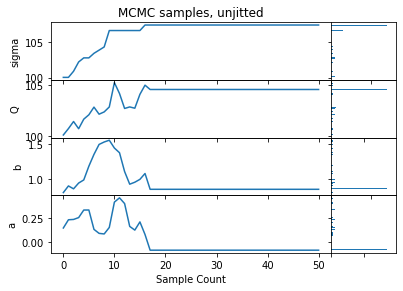

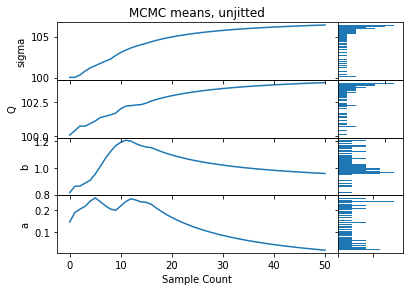

In [5]:
# Visualise results, unjitted.
traceplots(params_samples, xnames = ['a', 'b', 'Q', 'sigma'], title = 'MCMC samples, unjitted')
traceplots(params_means, xnames = ['a', 'b', 'Q', 'sigma'], title = 'MCMC means, unjitted')

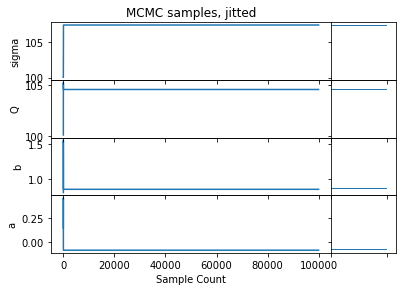

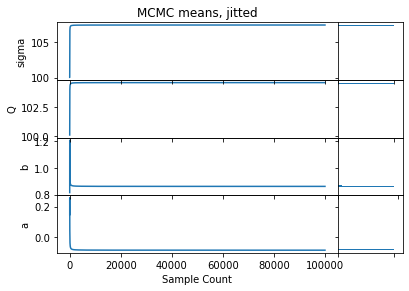

In [6]:
# Visualise results, jitted.
traceplots(params_samples_jit, xnames = ['a', 'b', 'Q', 'sigma'], title = 'MCMC samples, jitted')
traceplots(params_means_jit, xnames = ['a', 'b', 'Q', 'sigma'], title = 'MCMC means, jitted')

C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:239: RuntimeWarning: overflow encountered in exp
  C = Q / (tmp * np.pi*u) * (np.exp(-(y**2) / tmp)) * (np.exp(-(z-H)**2 / tmp) + np.exp(-(z+H)**2 / tmp))
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\1227948304.py:239: RuntimeWarning: overflow encountered in multiply
  C = Q / (tmp * np.pi*u) * (np.exp(-(y**2) / tmp)) * (np.exp(-(z-H)**2 / tmp) + np.exp(-(z+H)**2 / tmp))


Inferred means: x = -0.09, y = 0.86, z = 104.55.


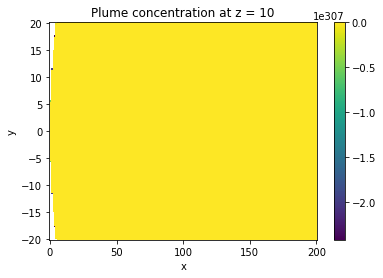

In [7]:
# Plot slices of the plume at set Z values using the mean values of the parameters.
# Jitted values adopted.

params_mean = params_means_jit[-1]
x = np.linspace(0.1, 200, 201)
y = np.linspace(-20, 20, 201)
#z = np.linspace(0, 400, 201)
X,Y = np.meshgrid(x, y)
Z = 10
C = C_func(X, Y, Z, wind_speed, params_mean[0], params_mean[1], params_mean[2], H)
plt.pcolor(X, Y, C, shading = 'auto')
plt.colorbar()
plt.title('Plume concentration at z = ' + str(Z))
plt.xlabel('x')
plt.ylabel('y')
print('Inferred means: x = ', round(params_mean[0], 2), ', y = ', round(params_mean[1], 2), ', z = ', round(params_mean[2], 2), '.', sep = '')

del(x)
del(y)

In [8]:
# Calculate the RMSE of this new model based on the data.
def RMSE_func(abQ, u, H, data):

    # Gaussian Plume Model for concentration.

    # Initialisations.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    piu = np.pi * u                    # Saved as np.float64.

    # Column 1 holds "x" values.
    precalc1 = 2 * abQ[0] * data[:,1] ** abQ[1]
    # Column 0 holds "Concentration" values.
    precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2

    # print(np.max(np.sqrt(precalc2)))

    RMSE = np.sqrt(sum(precalc2) / data.shape[0])
    print(' RMSE = ' + str(RMSE))
    return RMSE


RMSE = RMSE_func(params_mean, wind_speed, H, testing_data)

data_range = np.max(testing_data[:,0]) - np.min(testing_data[:,0])
print('Range = ' + str(data_range))

## saving_samples = pd.DataFrame({'a':params_samples[:,0],'b':params_samples[:,1],'Q':params_samples[:,2]})
# saving_samples = pd.DataFrame(params_samples,columns=['a','b','Q'])
# saving_samples.to_csv('samples.csv')

 RMSE = inf
Range = 10483.296070256554


C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\2190171313.py:15: RuntimeWarning: overflow encountered in exp
  precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\2190171313.py:15: RuntimeWarning: overflow encountered in multiply
  precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2
C:\Users\Sam\AppData\Local\Temp\ipykernel_19820\2190171313.py:15: RuntimeWarning: overflow encountered in square
  precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2


In [9]:
# Print the values of a, b and Q.
def print_vals(params_samples):

    params_samples = np.array(params_samples)
    vals = ['a','b','Q', 'sigma']
    for i in range(params_samples.shape[1]):
        print(vals[i] + ' = ' + str(np.mean(params_samples[:,i])) + ' +/- ' + str(np.std(params_samples[:,i])))

# Unjitted values.
print("Unjitted values:")
print_vals(params_samples)
print("")
# Jitted values.
print("Jitted values:")
print_vals(params_samples_jit)


Unjitted values:
a = 0.01846836817552033 +/- 0.1636635316976165
b = 0.9578186892068815 +/- 0.19615462430405983
Q = 103.89015337958901 +/- 1.2399537640615346
sigma = 106.41004971682862 +/- 2.036322825092995

Jitted values:
a = -0.08625117837167477 +/- 0.004388204715881959
b = 0.8617819277981754 +/- 0.004932468468475642
Q = 104.55353661351245 +/- 0.031759588710613275
sigma = 107.42650801609999 +/- 0.05140005750466579
